In [1]:
%matplotlib inline

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import time
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf
from matplotlib import pylab

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Step 1: Download the Data

In [2]:
url = 'http://mattmahoney.net/dc/'


def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
        statinfo = os.stat(filename)
        if statinfo.st_size == expected_bytes:
            print('Found and verified', filename)
        else:
            print(statinfo.st_size)
            raise Exception(
                'Failed to verify {}. \
                Can you get to it with a browser?'.format(
                    filename
                )
            )
    return filename

filename = maybe_download('text8.zip', 31344016)

### Read the data into a list of strings

In [3]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = f.read(f.namelist()[0]).split()
    return data

words = read_data(filename)
print('Data size', len(words))

Data size 17005207


## Step 2: Build the dictionary and replace rare words with UNK token

In [4]:
vocabulary_size = 50000


def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


## Step 3: Function to generate a training batch for the skip-gram model

In [5]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(
        batch[i],
        reverse_dictionary[batch[i]],
        '->',
        labels[i, 0],
        reverse_dictionary[labels[i, 0]]
    )

3084 originated -> 12 as
3084 originated -> 5239 anarchism
12 as -> 3084 originated
12 as -> 6 a
6 a -> 12 as
6 a -> 195 term
195 term -> 2 of
195 term -> 6 a


## Step 4: Build and train a skip-gram model

### Fetch the cluster definition

In [6]:
import ast

cluster_config = ast.literal_eval(os.environ.get('CLUSTER_CONFIG'))
cluster_spec = tf.train.ClusterSpec(cluster_config)
num_workers = len(cluster_config['worker'])
num_param_servers = len(cluster_config['ps'])
master_device = '/job:master/task:0'
print(cluster_config)

{'ps': ['ps-0.default.svc.cluster.local:8080', 'ps-1.default.svc.cluster.local:8080'], 'worker': ['worker-0.default.svc.cluster.local:8080', 'worker-1.default.svc.cluster.local:8080', 'worker-2.default.svc.cluster.local:8080', 'worker-3.default.svc.cluster.local:8080', 'worker-4.default.svc.cluster.local:8080', 'worker-5.default.svc.cluster.local:8080', 'worker-6.default.svc.cluster.local:8080', 'worker-7.default.svc.cluster.local:8080', 'worker-8.default.svc.cluster.local:8080', 'worker-9.default.svc.cluster.local:8080', 'worker-10.default.svc.cluster.local:8080', 'worker-11.default.svc.cluster.local:8080', 'worker-12.default.svc.cluster.local:8080', 'worker-13.default.svc.cluster.local:8080', 'worker-14.default.svc.cluster.local:8080', 'worker-15.default.svc.cluster.local:8080'], 'master': ['master-0.default.svc.cluster.local:8080']}


### Define Hyperparameters and validation set

In [7]:
batch_size = 256
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

### Build the model

In [8]:
graph = tf.Graph()
with graph.as_default():
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    with tf.device(master_device):
        # Input data.
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

        # Make one minibatch of data for each worker
        train_inputs_list = tf.split(0, num_workers, train_inputs)
        train_labels_list = tf.split(0, num_workers, train_labels)


    # Create a variable embedding for each parameter server
    embeddings = []
    for i in range(num_param_servers):
        with tf.device('/job:ps/task:{}'.format(i)):
            embeddings.append(
                tf.Variable(tf.random_uniform(
                    [vocabulary_size, embedding_size],
                    -1.0,
                    1.0
                ))
            )

    with tf.device(tf.train.replica_device_setter(cluster=cluster_spec)):
        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size],
                                stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
        global_step = tf.Variable(0)

    losses = []
    summaries = []
    # Assign computational tasks to each worker
    for i in range(num_workers):
        with tf.device('/job:worker/task:{}'.format(i)):
            # Look up embeddings for inputs.
            embed = tf.nn.embedding_lookup(embeddings, train_inputs_list[i])
            # Compute the average NCE loss for the batch.
            # tf.nce_loss automatically draws a new sample of the negative
            # labels each time we evaluate the loss.
            loss = tf.reduce_mean(
                tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels_list[i],
                               num_sampled, vocabulary_size))
            losses.append(loss)
            summaries.append(tf.scalar_summary("loss-{}".format(i), loss))


    with tf.device(master_device):
        average_loss_op = tf.add_n(losses) / tf.convert_to_tensor(num_workers, dtype=tf.float32)
        # Construct the SGD optimizer using a learning rate of 1.0.
        train_op = tf.train.GradientDescentOptimizer(1.0, use_locking=True).minimize(
            average_loss_op, global_step=global_step)
        
        summaries.append(tf.scalar_summary("average-loss", average_loss_op))
        summary_op = tf.merge_summary(summaries)
        init_op = tf.initialize_all_variables()
        
        # Compute the cosine similarity between minibatch examples
        # and the embeddings
        average_embeddings = tf.add_n(embeddings) / tf.convert_to_tensor(
            num_param_servers, dtype=tf.float32)
        
        norm = tf.sqrt(tf.reduce_sum(
                   tf.square(average_embeddings), 1, keep_dims=True))
        normalized_embeddings = average_embeddings / norm
        valid_embeddings = tf.nn.embedding_lookup(average_embeddings, valid_dataset)
        similarity = tf.matmul(
            valid_embeddings, normalized_embeddings, transpose_b=True)        
        

## Step 5: Begin Training

In [ ]:
num_steps = 100001


with tf.Session('grpc://localhost:8080', graph=graph) as session:
    init_op.run()
    print("Initialized")

    last_report_time = time.time()
    last_report_step = 0
    average_loss_total = 0
    step = 0
    timestamp = str(int(last_report_time))
    log_dir = '/var/log/tensorflow/word2vec_basic/summaries/{}'.format(
        timestamp)
    summary_writer = tf.train.SummaryWriter(log_dir, graph=graph)

    while step < num_steps:
        batch_inputs, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op
        # Also evaluate the training summary op
        # Average the workers' losses, and advance the global step
        _, summary, average_loss, step = session.run(
            [train_op, summary_op, average_loss_op, global_step],
            feed_dict=feed_dict
        )
        
        summary_writer.add_summary(summary, global_step=step)
        average_loss_total += average_loss
        cur_time = time.time()

        if cur_time > last_report_time + 10:
            # The average loss is an estimate of the loss over the last 2000
            # batches.
            steps = step - last_report_step
            print("Average loss at step {}: {} \t Steps/Second: {}".format(
                    step,
                    average_loss_total / steps,
                    steps / (cur_time - last_report_time)
            ))
            last_report_time = cur_time
            last_report_step = step
            average_loss_total = 0
            
            
            print("   Nearest words:")
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                print("      {}: {}".format(
                    valid_word, ', '.join(
                        reverse_dictionary[nearest[k]] for k in range(top_k)
                    ))
                )
    final_embeddings = [normalized_embeddings.eval()
                        for normalized_embeddings in normalized_embeddings_list]


Initialized
Average loss at step 13: 285.120578472 	 Steps/Second: 1.29178950792
   Nearest words:
      be: methodius, arms, aboriginals, talkin, okavango, karst, perlman, unconcerned
      called: replicant, tcl, mir, carlo, bootp, objects, ninja, pharaoh
      known: sassanians, offical, metastability, gottorp, necklaces, pairings, spader, phocas
      d: conflagration, knight, revisit, postal, drug, mathias, donating, sultan
      or: majapahit, oldest, bitten, aphelion, bluff, apologize, apa, msn
      seven: leu, monomers, solanas, aldermen, workstations, hejaz, frenchman, gallup
      th: chaplin, soaps, mindset, worrying, dissolve, lucretius, salon, lethe
      only: acheron, lossy, seaplane, liturgics, colonnade, laredo, smelling, congregations
      after: succumbed, fontainebleau, rhombic, severance, strictly, ciuszko, main, quarry
      UNK: germline, clinching, sir, coloring, posterior, gentler, trajectory, ntsc
      is: pools, phone, sacd, galician, najibullah, endangere

### Step 6: Visualize the embeddings

In [127]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    pylab.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        pylab.scatter(x, y)
        pylab.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    pylab.show()

plot_args = []
    
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
for final_embedding in final_embeddings:
    low_dim_embs = tsne.fit_transform(final_embedding[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_args.append((low_dim_embs, labels))

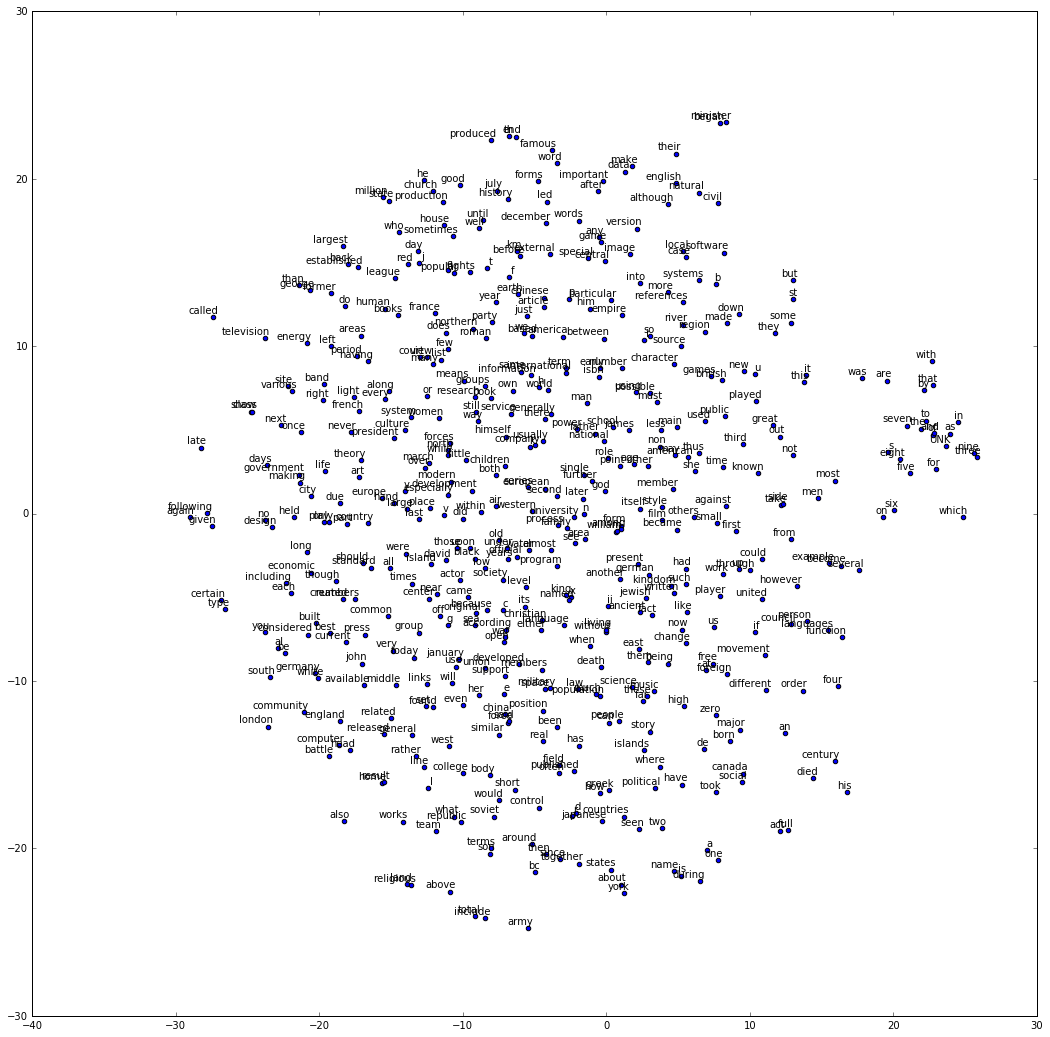

In [130]:
plot_with_labels(*plot_args[1])